# Data Wrangling and Analyzing the Tokenizer
This file cleans the data by pre-processing texts and removing noise. Finally it checks the results of Tokenization (with excellent results) and saves the clean text data to a csv.

## Setup

In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


In [ ]:
# Install compatible TensorFlow version
!pip uninstall tensorflow -y
!pip install tensorflow==2.15

# Reinstall tf-keras to resolve any potential dependency conflicts
!pip uninstall tf-keras -y
!pip install tf-keras

Import the necessary modules:

In [ ]:
!pip install tensorflow==2.15

In [ ]:
!pip uninstall tensorflow-text -y
!pip install tensorflow-text==2.15

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text as text
from tensorflow import keras

## Data handling



### Download the dataset

read the data

In [ ]:
# Read the CSV File
import pandas as pd

#tweets_df1 = pd.read_csv('train.csv')
tweets_df = pd.read_csv('train_enhanced.csv').drop_duplicates()

tweets_df.shape

(7613, 11)

In [ ]:
tweets_df.tail(3)

,index,id,keyword,location,text,target,sentiment,topic,irony,emotion,cleaned_text
24564,7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,{'label': 'neutral'},news_&_social_concern,{'label': 'non_irony'},{'label': 'joy'},M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
24572,7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,{'label': 'negative'},news_&_social_concern,{'label': 'non_irony'},{'label': 'fear'},Police investigating after an e-bike collided ...
24580,7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,{'label': 'neutral'},news_&_social_concern,{'label': 'irony'},{'label': 'fear'},The Latest: More Homes Razed by Northern Calif...


###Data Wrangling

In [ ]:
#creating training data from trainging data set
x_tweets = tweets_df['cleaned_text']
x_tweets = x_tweets.to_numpy() #need numpy for training

y_tweets = tweets_df['target']
y_tweets = y_tweets.to_numpy() #need numpy for training

#adding location
x_loc = tweets_df['location']

#adding keyword
x_kword =tweets_df['keyword']

#dont forget to shuffle


sanity checks

In [ ]:
# Sanity Checks:

print(x_tweets)
print(x_tweets.shape)
print(y_tweets)
print(y_tweets.shape)
print(x_loc)
print(x_loc.shape)
print(x_kword)
print(x_kword.shape)

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all negative  news_&_social_concern non_irony optimism'
 'Forest fire near La Ronge Sask. Canada neutral  news_&_social_concern non_irony fear'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected neutral  news_&_social_concern non_irony disgust"
 ...
 'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ neutral  news_&_social_concern non_irony joy'
 'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries. negative  news_&_social_concern non_irony fear'
 'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d neutral  news_&_social_concern irony fear']
(7613,)
[1 1 1 ... 1 1 1]
(7613,)
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
24555    NaN
24556    NaN
24564    NaN
2457

 Just using the raw tweets without any data cleansing will not give us the results we want to see. For example obscure symbols, parenthesis, and other marks will negatively impact the NLP model since they add noise to the input data and make it hard for the algorithm to understand the text and can also potentially cause the model to overfit to the training data. For this project, five functions were created for data cleaning.

### add padding at the end:
This function was created to add a space between the end of the end of the sentence and the end of the string,
it will help us with data wrangling

In [ ]:
def insert_end_padding(ds_array1):
    # Vectorize the operation of adding a space at the end of each string
    vectorized_add_space = np.vectorize(lambda s: s + ' ')
    # Apply the operation to the entire array
    ds_array1 = vectorized_add_space(ds_array1)
    return ds_array1

In [ ]:
print(len(x_tweets[1]))
x_tweets = insert_end_padding(x_tweets)
print(len(x_tweets[1]))


84
85


### Insert Keyword Function:

This function was created so that the keyword in the keyword field of the training data can be added into the text field.

In [ ]:
def insert_keyword(ds_array1, ds_array2):
    # Ensure the input is a numpy array with the correct shape
    ds_array1 = np.array(ds_array1, dtype=str)
    ds_array2 = np.array(ds_array2, dtype=str)

    # Iterate over the array and insert the keyword

    for i in range(ds_array1.shape[0]):
      text = ds_array1[i]
      flag = len(ds_array2[i])
      if flag > 1:

        ds_array1[i] = ds_array2[i] + ' ' + ds_array1[i]


    return ds_array1


In [ ]:
print(x_kword[100])
print(x_tweets[100])
x_tweets = insert_keyword(x_tweets, x_kword)
print(x_tweets[100])


accident
.@NorwayMFA Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad neutral  news_&_social_concern non_irony fear 
accident .@NorwayMFA Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad neutral  news_&_social_concern non_irony fear 


### Insert Marker Function:

Some tweets have locations identified, the goal of this function is to add the location from the location field into the tweet so that the algorithm can take note of the location.

In [ ]:
def insert_marker(ds_array1, ds_array2, insertion):
    # Ensure the input is a numpy array with the correct shape
    ds_array1 = np.array(ds_array1, dtype=str)
    ds_array2 = np.array(ds_array2, dtype=str)

    # Iterate over the array and insert the marker
    for i in range(ds_array1.shape[0]):

        text = ds_array1[i]
        flag = len(ds_array2[i])
        if flag > 1:
          ds_array1[i] = insertion + ' ' + text
    return ds_array1

In [ ]:
## Adding Location Into the tweet texts:
print(x_loc[31])
print(x_tweets[31])
x_tweets = insert_marker(x_tweets, x_loc, 'location')
print(x_tweets[31])

Birmingham
ablaze @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C neutral  news_&_social_concern irony anger 
location ablaze @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C neutral  news_&_social_concern irony anger 


### lowercase_ch Function:
Convert everything into lowercase so that the model knows "Disaster" and "disaster" are one word and not two words.

In [ ]:
def lowercase_ch(ds_array):
    # Ensure the input is a numpy array
    ds_array = np.array(ds_array, dtype=str)
    # Vectorize the lowercase operation
    vectorized_lower = np.vectorize(lambda s: s.lower())
    # Apply the operation to the entire array
    return vectorized_lower(ds_array)

In [ ]:
print(x_tweets [0])
x_tweets = lowercase_ch(x_tweets)
x_kword = lowercase_ch(x_kword)
x_loc = lowercase_ch(x_loc)
print(x_tweets [0])

location nan Our Deeds are the Reason of this earthquake May ALLAH Forgive us all negative  news_&_social_concern non_irony optimism 
location nan our deeds are the reason of this earthquake may allah forgive us all negative  news_&_social_concern non_irony optimism 


### remove_ch Function:

This function was created to remove any special characters from the text that are not needed for the algorithm such as  "(" or "+" etc..

In [ ]:
def remove_ch(ds_array, target, replacement):
    """
    This function replaces all occurrences of the target character with the replacement character in a 2D numpy array.

    Parameters:
    ds_array (numpy.ndarray): The 2D numpy array containing strings.
    target (str): The character to be replaced.
    replacement (str): The character to replace with.

    Returns:
    numpy.ndarray: The updated 2D numpy array with the target character replaced.
    """
    for i in range(ds_array.shape[0]):
        anytext = ds_array[i]
        ds_array[i] = anytext.replace(target, replacement)
    return ds_array

In [ ]:
print(x_tweets[31])
x_tweets = remove_ch(x_tweets, '@', '')
print(x_tweets[31])

location ablaze @bbcmtd wholesale markets ablaze http://t.co/lhyxeohy6c neutral  news_&_social_concern irony anger 
location ablaze bbcmtd wholesale markets ablaze http://t.co/lhyxeohy6c neutral  news_&_social_concern irony anger 


Removing Special Characters

In [ ]:
x_tweets = remove_ch(x_tweets, 'http:', 'weblink ')
x_tweets = remove_ch(x_tweets, ';', '')
x_tweets = remove_ch(x_tweets, '%20', ' ') #it doesnt like it but should make it more generalizzable
x_tweets = remove_ch(x_tweets, '%', '') #one of the top keywords is body%20bags, but tokenization make it oov
x_tweets = remove_ch(x_tweets, '+', '')#adding a space hurts it?
x_tweets = remove_ch(x_tweets, '....', '')
x_tweets = remove_ch(x_tweets, '...', '')
x_tweets = remove_ch(x_tweets, '..', '')
x_tweets = remove_ch(x_tweets, '.', ' ')#insert a space, seemed to improve results
x_tweets = remove_ch(x_tweets, '_', ' ')
x_tweets = remove_ch(x_tweets, ':', '')
x_tweets = remove_ch(x_tweets, ';', '')
x_tweets = remove_ch(x_tweets, '&', ' ') #space brings it up by 0.5 accuracy
x_tweets = remove_ch(x_tweets, '*', '')
x_tweets = remove_ch(x_tweets, '(', '')
x_tweets = remove_ch(x_tweets, ')', '')
x_tweets = remove_ch(x_tweets, ',', '')
x_tweets = remove_ch(x_tweets, '-', '') #inserting a space hurts it
x_tweets = remove_ch(x_tweets, '\'', '')
x_tweets = remove_ch(x_tweets, '\"', '')

x_tweets = remove_ch(x_tweets, ']', '')
x_tweets = remove_ch(x_tweets, '[', '')
x_tweets = remove_ch(x_tweets, '{', '')
x_tweets = remove_ch(x_tweets, '}', '')
x_tweets = remove_ch(x_tweets, '<', '')
x_tweets = remove_ch(x_tweets, '>', '')
x_tweets = remove_ch(x_tweets, '~', '')


x_tweets = remove_ch(x_tweets, '#', '')
x_tweets = remove_ch(x_tweets, '\x89Û', ' ')#These are emojis that were converted into text. Should be a space? small potat
x_tweets = remove_ch(x_tweets, '÷', ' ')#tis should be a space, small potato?
x_tweets = remove_ch(x_tweets, '!!!', '')
x_tweets = remove_ch(x_tweets, '!!', '')
x_tweets = remove_ch(x_tweets, '!', '')
x_tweets = remove_ch(x_tweets, '???', '')
x_tweets = remove_ch(x_tweets, '??', '')
x_tweets = remove_ch(x_tweets, '?', '')
x_tweets = remove_ch(x_tweets, '$$$$', '')
x_tweets = remove_ch(x_tweets, '$$$', '')
x_tweets = remove_ch(x_tweets, '$$', '')
x_tweets = remove_ch(x_tweets, '$', '')

# Removing this charector from x_tweets causes accuracy to drop
x_tweets = remove_ch(x_tweets, 'åÈ', '')
x_tweets = remove_ch(x_tweets, '//t', '')
x_tweets = remove_ch(x_tweets, '|', ' ')
x_tweets = remove_ch(x_tweets, '==', ' ')
x_tweets = remove_ch(x_tweets, '=', ' ')
x_tweets = remove_ch(x_tweets, 'nan', ' ')




Removing Doubles Spaces
<p>After the data wrangling many double spaces are created,that must be removed as much as possible</p>

In [ ]:
def remove_double_space(string_array, word_a, word_b):
    """
    This function replaces all occurrences of two consecutive spaces with a single space in a 2D numpy array.

    Parameters:
    string_array (numpy.ndarray): The 2D numpy array containing strings.
    word_a (str): The substring to be replaced (typically two spaces).
    word_b (str): The substring to replace with (typically one space).

    Returns:
    numpy.ndarray: The updated 2D numpy array with double spaces replaced by single spaces.
    """
    for i in range(string_array.shape[0]):
        flag = True
        while flag:
            substring = string_array[i]
            if word_a in substring:
                string_array[i] = substring.replace(word_a, word_b)
            else:
                flag = False
    return string_array

# Example usage:
# Assuming string_array is a 2D numpy array with strings, word_a is the substring to be replaced,
# and word_b is the new substring.
# updated_string_array = remove_double_space(string_array, word_a, word_b)



###Remove words with special patterns

In [ ]:
import re
def remove_text_sequences_from_array(array):
    # Define the pattern to match text sequences starting with 'co/' and ending with the next space
    pattern = r"co/\S+"

    # Use numpy vectorize function to apply the cleaning to each element in the array
    vectorized_remove = np.vectorize(lambda sentence: re.sub(pattern, "", sentence))

    # Apply the function to the array
    cleaned_array = vectorized_remove(array)

    return cleaned_array


Removed left overs after http was replaced with 'weblink' marker

In [ ]:
print(x_tweets[40])
x_tweets = remove_text_sequences_from_array(x_tweets)
print(x_tweets[40])

location ablaze check these out weblink  co/roi2nsmejj weblink  co/3tj8zjin21 weblink  co/yduixefipe weblink  co/lxtjc87kls nsfw neutral  news   social concern non irony anticipation 
location ablaze check these out weblink   weblink   weblink   weblink   nsfw neutral  news   social concern non irony anticipation 


In [ ]:
x_tweets = remove_ch(x_tweets, '/', ' ')

## Set up the tokenizer

Inputting our data into the tokenizer as a way to measure the success of the data wrangling.

In [ ]:
#sentences = tweets_df['text']
sentences = x_tweets
labels = tweets_df['target']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Instantiate the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your text data
tokenizer.fit_on_texts(sentences)

# Create a set of all words that the tokenizer has seen during fit
word_index = set(tokenizer.word_index.keys())

In [ ]:
MAX_TOKENS =30
# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')

# Convert labels to NumPy array, why?
#labels = labels.to_numpy()

labels = y_tweets

In [ ]:
print("total shape: ",sequences.shape)
print("type: ",type(sequences))
for i in range(9,10):
  print('shape :', sequences[0].shape)
  print('type: ', type(sequences[0]))

  print(f"-----------------batch'{[i]}'-----------------")

  print(sentences[i])
  print(sequences[i])
  print(sequences[i].dtype)

  print(tokenizer.sequences_to_texts([sequences[i]]))
  print(f"\n")



total shape:  (7613, 30)
type:  <class 'numpy.ndarray'>
shape : (30,)
type:  <class 'numpy.ndarray'>
-----------------batch'[9]'-----------------
location   im afraid that the tornado is coming to our area negative  news   social concern non irony fear 
[   4   51 2441   31    9  315   20  437   13  142  516   10    1    2
    3    6    5   15    0    0    0    0    0    0    0    0    0    0
    0    0]
int32
['location im afraid that the tornado is coming to our area negative news social concern non irony fear']




####Identify Unknown Words by Tokenizer

In [ ]:
# Function to identify words not found by the tokenizer
def find_unknown_words(sentences, word_index):
    unknown_words = set()
    known_words = set()
    # Iterate over each sentence
    for sentence in sentences:
        # Tokenize the sentence into words
        words = sentence.lower().split()  # Convert to lowercase and split
        # Check if each word is in the tokenizer's word index
        for word in words:
            word = word.strip()  # Strip whitespace
            if word not in word_index:
                unknown_words.add(word)
            else:
                known_words.add(word)
    return unknown_words, known_words


In [ ]:
unknown_words, known_words = find_unknown_words(sentences, word_index)

In [ ]:
# Call the function and print the unknown words
print(f"Words found by the tokenizer: {len(known_words)}")
print(f"Words not found by the tokenizer: {len(unknown_words)}")

Words found by the tokenizer: 17980
Words not found by the tokenizer: 9


In [ ]:
for i in range(len(unknown_words)):
  print(list(unknown_words)[i])

`bbcnews
^oo^
^ag
^mp
\\\
3\30a
destruction\s
didn`t
^sj


Our Datawrangling is very good, and the Tokenization is very good, it leaves out very few words.

####Histogram of Tokens in our Dataset

The distribution of tokens per example in the dataset is as follows:

In [ ]:
# Tokenize the sentences
tokenized_sentences = tokenizer.texts_to_sequences(x_tweets)


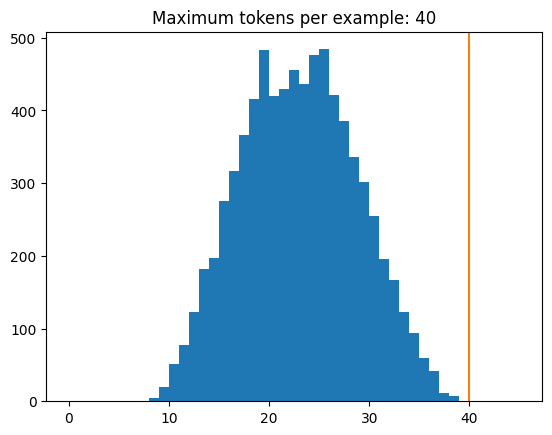

In [ ]:




# Calculate the lengths of the tokenized sentences
lengths = [len(sentence) for sentence in tokenized_sentences]

# Plot the histogram of lengths
plt.hist(lengths, np.linspace(0, 45, 46))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');


###Saved Cleaned Data

In [ ]:
# Create a DataFrame from the numpy arrays
df = pd.DataFrame({'text': x_tweets, 'target': y_tweets})

# Save the DataFrame to a CSV file
df.to_csv('./train_enhanced_cleaned.csv', index=False)

#End